In [ ]:
import os
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import f1_score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

def load_and_preprocess_images(path, img_height, img_width, batch_size):
    dataset = image_dataset_from_directory(
        path,
        color_mode='grayscale',
        label_mode=None,  # We don't need labels for GAN training
        image_size=(img_height, img_width),
        batch_size=batch_size)

    # Normalize images to [0, 1]
    dataset = dataset.map(lambda x: (x - 127.5)/ 127.5)
    return dataset

image_height = 64
image_width = 64
batch_size = 16

dataset = load_and_preprocess_images('/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/images', image_height, image_width, batch_size)


Found 1345 files belonging to 1 classes.


In [ ]:
image_height = 64
image_width = 64
batch_size = 16

In [ ]:
from tensorflow.keras import layers, models

import tensorflow as tf
from tensorflow.keras import layers

noise_dim = 200

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


generator = make_generator_model()
discriminator = make_discriminator_model()


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


Time for epoch 1 is 28.290163278579712 sec
Generator loss: 4.60065221786499, Discriminator loss: 0.42221155762672424
Time for epoch 2 is 26.8117516040802 sec
Generator loss: 4.113033294677734, Discriminator loss: 0.3399414122104645
Time for epoch 3 is 40.955570459365845 sec
Generator loss: 3.8790438175201416, Discriminator loss: 0.5881741046905518
Time for epoch 4 is 29.21744155883789 sec
Generator loss: 2.9008913040161133, Discriminator loss: 0.48979172110557556
Time for epoch 5 is 40.95338034629822 sec
Generator loss: 4.852305889129639, Discriminator loss: 0.44273412227630615
Time for epoch 6 is 27.19808292388916 sec
Generator loss: 2.0488028526306152, Discriminator loss: 0.5190606117248535
Time for epoch 7 is 27.266629695892334 sec
Generator loss: 2.836500406265259, Discriminator loss: 0.4742167890071869
Time for epoch 8 is 27.091545820236206 sec
Generator loss: 3.38531494140625, Discriminator loss: 0.44128966331481934
Time for epoch 9 is 26.388994693756104 sec
Generator loss: 2.964

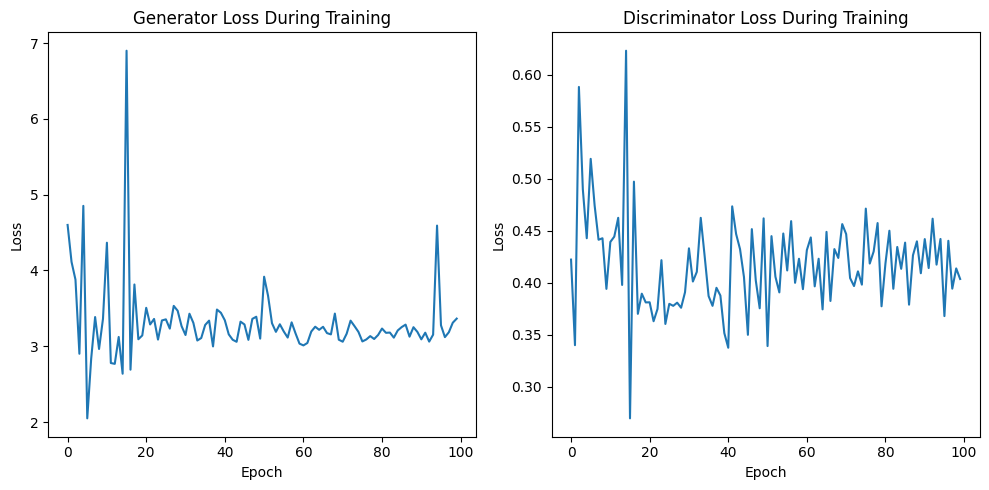

In [ ]:
import time
from IPython import display

def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0

        for image_batch in dataset:
            train_step(image_batch)
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            num_batches += 1

        gen_losses.append(total_gen_loss / num_batches)
        disc_losses.append(total_disc_loss / num_batches)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print('Generator loss: {}, Discriminator loss: {}'.format(gen_losses[-1], disc_losses[-1]))

    return gen_losses, disc_losses


gen_losses, disc_losses = train(dataset, epochs=100)



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss During Training')

plt.subplot(1, 2, 2)
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss During Training')

plt.tight_layout()
plt.show()

In [ ]:
# # Saving the weights
# generator.save_weights('/content/Viral_Pneumonia_generator_weights.h5')
# discriminator.save_weights('/content/Viral_Pneumonia_discriminator_weights.h5')

In [ ]:
# Loading the weights
generator.load_weights('/content/Viral_Pneumonia_generator_weights-2.h5')
discriminator.load_weights('/content/Viral_Pneumonia_discriminator_weights-2.h5')

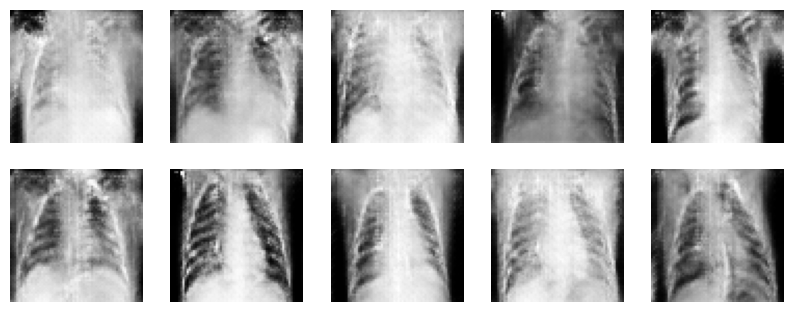

In [ ]:
def generate_and_show_images(model, num_images=10):
    noise = tf.random.normal([num_images, noise_dim])

    generated_images = model(noise, training=False)

    generated_images = ((generated_images + 127.5) * 127.5).numpy()

    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated_images[i].astype(np.uint8), cmap='gray')
        plt.axis('off')

    plt.show()

generate_and_show_images(generator)


### Organize Files

In [ ]:
import shutil
# folder_path = '/content/test'
# folder_path = '/content/train'
# folder_path = '/content/generated'
# folder_path = '/content/testt'
# folder_path = '/content/trainn'

# Check if the folder exists
if os.path.exists(folder_path):
    # Remove the folder and all its contents
    shutil.rmtree(folder_path)
    print(f"The folder at {folder_path} has been deleted.")
else:
    print(f"The folder at {folder_path} does not exist.")


The folder at /content/generated has been deleted.


In [ ]:
import os
import shutil
import numpy as np
import random

base_dir = '/content'
classes = ['COVID', 'Pneumonia', 'Normal']
dirs = ['/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/images',
        '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral_Pneumonia/images',
        '/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal/images']  # The class names

train_ratio = 0.8

for dir, cls in zip(dirs, classes):
    os.makedirs(os.path.join(base_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', cls), exist_ok=True)

    all_files = os.listdir(dir)
    if cls == 'Normal':
      random.seed(10)
      all_files = random.sample(all_files, 3817)

    np.random.shuffle(all_files)

    split_index = int(train_ratio * len(all_files))
    train_files = all_files[:split_index]
    test_files = all_files[split_index:]

    for file_name in train_files:
        shutil.copy(os.path.join(dir, file_name), os.path.join(base_dir, 'train', cls))

    for file_name in test_files:
        shutil.copy(os.path.join(dir, file_name), os.path.join(base_dir, 'test', cls))


### Generate Images

In [ ]:
# num_images=1771
num_images=1800
noise = tf.random.normal([num_images, 200])  # 200 is the dimension of the noise vector

generated_images = generator(noise, training=False)

generated_images = ((generated_images + 127.5) * 127.5).numpy()

save_dir = '/content/generated'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i, img in enumerate(generated_images):
    if img.ndim == 3 and img.shape[2] == 1:
        img = np.squeeze(img, axis=2)
    img = Image.fromarray(img.astype('uint8'), 'L')
    img.save(os.path.join(save_dir, f'generated_image_{i}.png'))

In [ ]:
import os
import shutil

source_dir = '/content/generated'
destination_dir = '/content/train/Pneumonia'

In [ ]:
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)
    if os.path.isfile(file_path):
        shutil.copy(file_path, destination_dir)

In [ ]:
import os

# Specify the directory path
folder_path = '/content/train/COVID'
# folder_path = '/content/train/Normal'
# folder_path = '/content/train/Pneumonia'
# folder_path = '/content/train'
# folder_path = '/content/generated'
# folder_path = '/content/testt'
# folder_path = '/content/trainn'

# List all files in the directory
files_in_directory = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Count the number of files
number_of_files = len(files_in_directory)

print(f"There are {number_of_files} files in the directory.")


There are 2892 files in the directory.


### ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    # labels="inferred",
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/test',
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_ds_ = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_ = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


import tensorflow as tf

def preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_ds_augmented = train_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_augmented = val_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

test_ds_processed = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_augmented_Res = train_ds_augmented.prefetch(tf.data.AUTOTUNE)
val_ds_augmented_Res = train_ds_augmented.prefetch(tf.data.AUTOTUNE)
test_ds_processed_Res = test_ds_processed.prefetch(tf.data.AUTOTUNE)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3)(x)


ResNet_model = Model(inputs=base_model.input, outputs=predictions)


ResNet_model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history = ResNet_model.fit(
    train_ds_augmented_Res,
    epochs=epochs,
    validation_data=val_ds_augmented_Res
)

Found 8821 files belonging to 3 classes.
Using 7057 files for training.
Found 1757 files belonging to 3 classes.
Found 8821 files belonging to 3 classes.
Using 1764 files for validation.
Epoch 1/10
442/442 [==============================] - 29s 28ms/step - loss: 0.6825 - accuracy: 0.7896 - val_loss: 0.2630 - val_accuracy: 0.8964
Epoch 2/10
442/442 [==============================] - 16s 36ms/step - loss: 0.3848 - accuracy: 0.8429 - val_loss: 0.2418 - val_accuracy: 0.9058
Epoch 3/10
442/442 [==============================] - 16s 36ms/step - loss: 0.3108 - accuracy: 0.8759 - val_loss: 0.2276 - val_accuracy: 0.9049
Epoch 4/10
442/442 [==============================] - 14s 31ms/step - loss: 0.2721 - accuracy: 0.8893 - val_loss: 0.1698 - val_accuracy: 0.9259
Epoch 5/10
442/442 [==============================] - 12s 28ms/step - loss: 0.2479 - accuracy: 0.8968 - val_loss: 0.1355 - val_accuracy: 0.9449
Epoch 6/10
442/442 [==============================] - 12s 26ms/step - loss: 0.2352 - accuracy

In [ ]:
test_loss, test_accuracy = ResNet_model.evaluate(test_ds_processed_Res)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

110/110 [==============================] - 7s 57ms/step - loss: 0.3428 - accuracy: 0.8981
Test Loss: 0.34279775619506836
Test Accuracy: 0.8981217741966248


In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score
import numpy as np


def calculate_f1_score(model):
    true_labels = []
    predicted_labels = []

    for images, labels in test_ds_processed_Res:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        print(np.unique(pred_labels))
        true_labels.extend(labels.numpy())
        predicted_labels.extend(pred_labels)

    true_labels = np.array(true_labels).flatten()
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1


f1 = calculate_f1_score(ResNet_model)
print("F1 Score:", f1)

1/1 [==============================] - 1s 1s/step
[0 1 2]
1/1 [==============================] - 0s 27ms/step
[0 1 2]
1/1 [==============================] - 0s 25ms/step
[0 1 2]
1/1 [==============================] - 0s 31ms/step
[0 1 2]
1/1 [==============================] - 0s 25ms/step
[0 1 2]
1/1 [==============================] - 0s 28ms/step
[0 1 2]
1/1 [==============================] - 0s 24ms/step
[0 1 2]
1/1 [==============================] - 0s 26ms/step
[0 1 2]
1/1 [==============================] - 0s 25ms/step
[0 1 2]
1/1 [==============================] - 0s 30ms/step
[0 1 2]
1/1 [==============================] - 0s 27ms/step
[0 1 2]
1/1 [==============================] - 0s 29ms/step
[0 1 2]
1/1 [==============================] - 0s 29ms/step
[0 1 2]
1/1 [==============================] - 0s 30ms/step
[0 1 2]
1/1 [==============================] - 0s 26ms/step
[0 1 2]
1/1 [==============================] - 0s 30ms/step
[0 1 2]
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 29ms/step


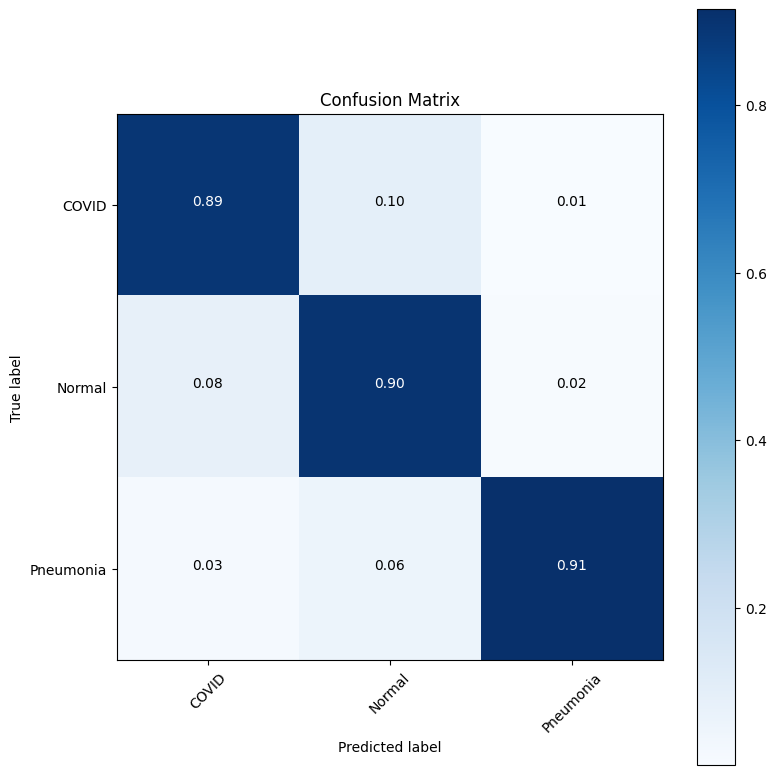

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

y_true = []
y_pred = []

for img, label in test_ds_processed_Res:
    y_true.extend(label.numpy())
    predictions = ResNet_model.predict(img)
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

fig = plot_confusion_matrix(cm, class_names)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.plot(history['accuracy'], label='Training Accuracy')
  ax1.plot(history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend()

  ax2.plot(history['loss'], label='Training Loss')
  ax2.plot(history['val_loss'], label='Validation Loss')
  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend()

  plt.tight_layout()
  plt.show()

###DenseNet

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="training",
    seed=37,
    image_size=(image_height, image_width),
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/test',
    seed=37,
    image_size=(image_height, image_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="validation",
    seed=37,
    image_size=(image_height, image_width),
    batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_ds_ = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_ = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


def preprocess(image, label):
    image = tf.keras.applications.densenet.preprocess_input(image)
    return image, label

train_ds_augmented_Dense = train_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_augmented_Dense = val_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

test_ds_processed_Dense = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_augmented_Dense = train_ds_augmented_Dense.prefetch(tf.data.AUTOTUNE)
val_ds_augmented_Dense = val_ds_augmented_Dense.prefetch(tf.data.AUTOTUNE)
test_ds_processed_Dense = test_ds_processed_Dense.prefetch(tf.data.AUTOTUNE)

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3)(x)

DenseNet_model = Model(inputs=base_model.input, outputs=predictions)

DenseNet_model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

epochs = 10
history_Dense = DenseNet_model.fit(
    train_ds_augmented_Dense,
    epochs=epochs,
    validation_data=val_ds_augmented_Dense
)

Found 8821 files belonging to 3 classes.
Using 7057 files for training.
Found 1757 files belonging to 3 classes.
Found 8821 files belonging to 3 classes.
Using 1764 files for validation.
Epoch 1/10
442/442 [==============================] - 33s 34ms/step - loss: 0.5614 - accuracy: 0.7917 - val_loss: 0.3127 - val_accuracy: 0.8736
Epoch 2/10
442/442 [==============================] - 13s 29ms/step - loss: 0.3669 - accuracy: 0.8502 - val_loss: 0.2683 - val_accuracy: 0.8968
Epoch 3/10
442/442 [==============================] - 11s 25ms/step - loss: 0.3203 - accuracy: 0.8696 - val_loss: 0.2430 - val_accuracy: 0.9008
Epoch 4/10
442/442 [==============================] - 10s 23ms/step - loss: 0.2944 - accuracy: 0.8784 - val_loss: 0.2507 - val_accuracy: 0.9036
Epoch 5/10
442/442 [==============================] - 11s 26ms/step - loss: 0.2860 - accuracy: 0.8838 - val_loss: 0.2642 - val_accuracy: 0.9025
Epoch 6/10
442/442 [==============================] - 11s 26ms/step - loss: 0.2616 - accuracy

In [ ]:
test_loss, test_accuracy = DenseNet_model.evaluate(test_ds_processed_Dense)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

110/110 [==============================] - 4s 36ms/step - loss: 0.2969 - accuracy: 0.8902
Test Loss: 0.2968735694885254
Test Accuracy: 0.8901536464691162


1/1 [==============================] - 0s 32ms/step


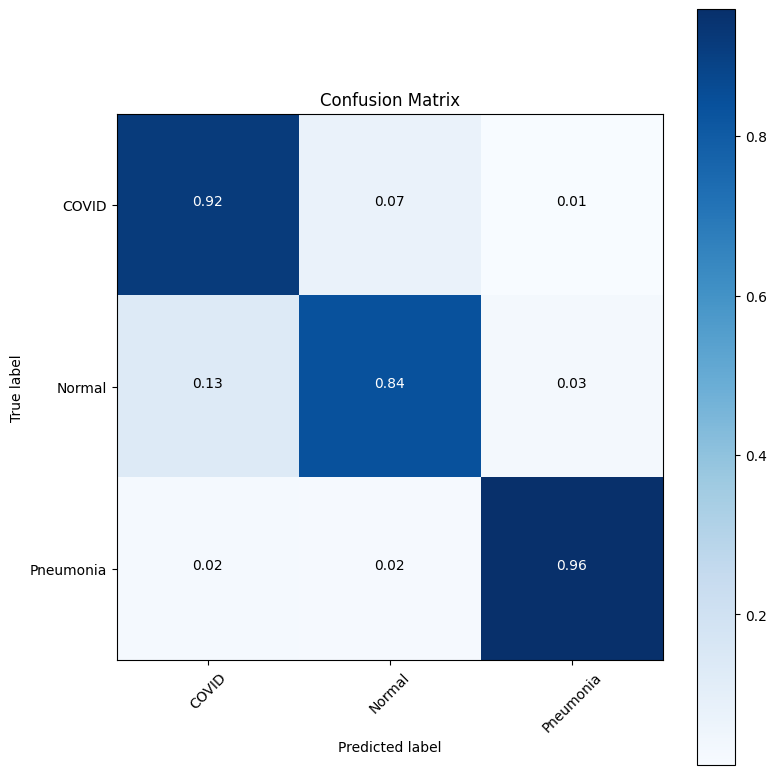

In [ ]:
def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

y_true = []
y_pred = []

for img, label in test_ds_processed_Dense:
    y_true.extend(label.numpy())
    predictions = DenseNet_model.predict(img)
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

fig = plot_confusion_matrix(cm, class_names)
plt.show()

In [ ]:
def calculate_f1_score(model):
    true_labels = []
    predicted_labels = []

    for images, labels in test_ds_processed_Dense:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        print(np.unique(pred_labels))
        true_labels.extend(labels.numpy())
        predicted_labels.extend(pred_labels)

    true_labels = np.array(true_labels).flatten()
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1


f1 = calculate_f1_score(DenseNet_model)
print("F1 Score:", f1)

1/1 [==============================] - 0s 51ms/step
[0 1 2]
1/1 [==============================] - 0s 30ms/step
[0 1 2]
1/1 [==============================] - 0s 30ms/step
[0 1 2]
1/1 [==============================] - 0s 37ms/step
[0 1 2]
1/1 [==============================] - 0s 36ms/step
[0 1 2]
1/1 [==============================] - 0s 33ms/step
[0 1 2]
1/1 [==============================] - 0s 34ms/step
[0 1 2]
1/1 [==============================] - 0s 36ms/step
[0 1 2]
1/1 [==============================] - 0s 35ms/step
[0 1 2]
1/1 [==============================] - 0s 34ms/step
[0 1 2]
1/1 [==============================] - 0s 37ms/step
[0 1 2]
1/1 [==============================] - 0s 29ms/step
[0 1 2]
1/1 [==============================] - 0s 37ms/step
[0 1 2]
1/1 [==============================] - 0s 40ms/step
[0 1 2]
1/1 [==============================] - 0s 36ms/step
[0 1 2]
1/1 [==============================] - 0s 36ms/step
[0 1 2]
1/1 [==============================] - 0

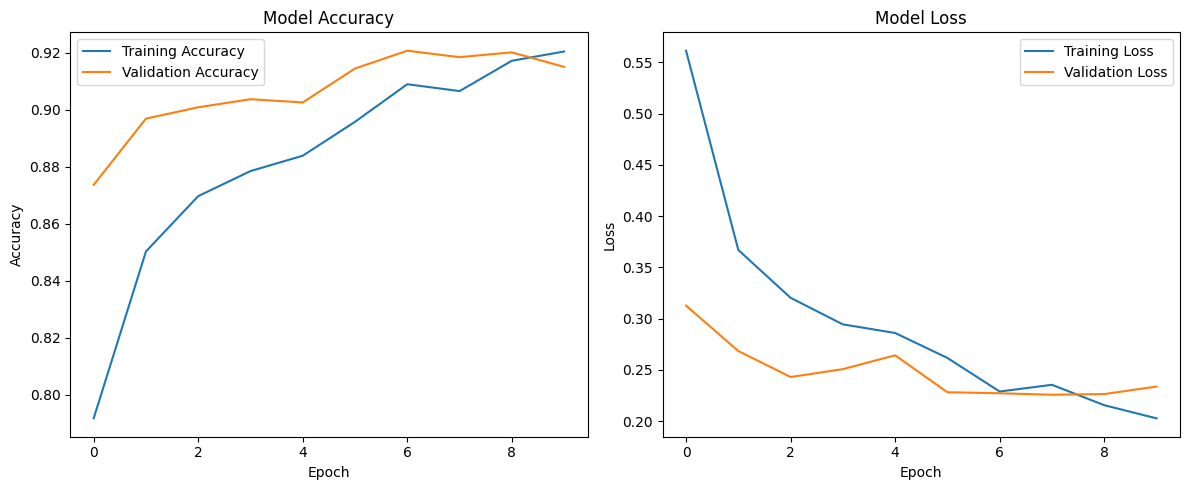

In [ ]:
import matplotlib.pyplot as plt

plot_learning_curve(history_Dense.history)

### InceptionResNet

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(299, 299),
    batch_size=8)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/test',
    seed=123,
    image_size=(299, 299),
    batch_size=8)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(299, 299),
    batch_size=8)

AUTOTUNE = tf.data.AUTOTUNE

train_ds_ = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_ = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def preprocess(image, label):
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

train_ds_augmented_IncRes = train_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_augmented_IncRes = val_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

test_ds_processed_IncRes = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_augmented_IncRes = train_ds_augmented_IncRes.prefetch(tf.data.AUTOTUNE)
val_ds_augmented_IncRes = val_ds_augmented_IncRes.prefetch(tf.data.AUTOTUNE)
test_ds_processed_IncRes = test_ds_processed_IncRes.prefetch(tf.data.AUTOTUNE)

base_model = InceptionResNetV2(weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3)(x)

IncRes_model = Model(inputs=base_model.input, outputs=predictions)


IncRes_model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

epochs = 10
history = IncRes_model.fit(
    train_ds_augmented_IncRes,
    epochs=epochs,
    validation_data=val_ds_augmented_IncRes
)

Found 8821 files belonging to 3 classes.
Using 7057 files for training.
Found 1757 files belonging to 3 classes.
Found 8821 files belonging to 3 classes.
Using 1764 files for validation.
Epoch 1/10
883/883 [==============================] - 112s 87ms/step - loss: 0.5489 - accuracy: 0.7339 - val_loss: 0.4611 - val_accuracy: 0.7846
Epoch 2/10
883/883 [==============================] - 71s 80ms/step - loss: 0.4450 - accuracy: 0.7842 - val_loss: 0.4332 - val_accuracy: 0.7920
Epoch 3/10
883/883 [==============================] - 70s 80ms/step - loss: 0.4156 - accuracy: 0.8049 - val_loss: 0.4073 - val_accuracy: 0.8163
Epoch 4/10
883/883 [==============================] - 71s 80ms/step - loss: 0.3884 - accuracy: 0.8192 - val_loss: 0.3925 - val_accuracy: 0.8220
Epoch 5/10
883/883 [==============================] - 71s 80ms/step - loss: 0.3678 - accuracy: 0.8325 - val_loss: 0.3847 - val_accuracy: 0.8203
Epoch 6/10
883/883 [==============================] - 72s 82ms/step - loss: 0.3556 - accurac

In [ ]:
test_loss, test_accuracy = IncRes_model.evaluate(test_ds_processed_IncRes)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

220/220 [==============================] - 15s 67ms/step - loss: 0.4417 - accuracy: 0.8253
Test Loss: 0.4416753649711609
Test Accuracy: 0.8252703547477722


1/1 [==============================] - 0s 41ms/step


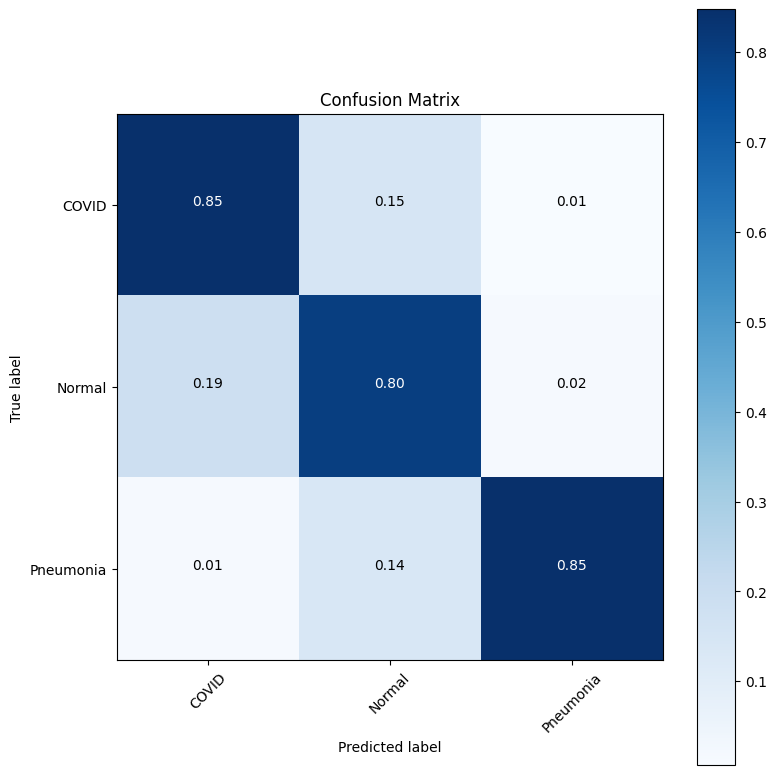

In [ ]:
def plot_confusion_matrix(cm, class_names):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

y_true = []
y_pred = []

for img, label in test_ds_processed_IncRes:
    y_true.extend(label.numpy())
    predictions = IncRes_model.predict(img)
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

fig = plot_confusion_matrix(cm, class_names)
plt.show()

In [ ]:
def calculate_f1_score(model):
    true_labels = []
    predicted_labels = []

    for images, labels in test_ds_processed_IncRes:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        print(np.unique(pred_labels))
        true_labels.extend(labels.numpy())
        predicted_labels.extend(pred_labels)

    true_labels = np.array(true_labels).flatten()
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1


f1 = calculate_f1_score(IncRes_model)
print("F1 Score:", f1)

1/1 [==============================] - 0s 74ms/step
[0 1 2]
1/1 [==============================] - 0s 62ms/step
[0 1 2]
1/1 [==============================] - 0s 72ms/step
[0 1 2]
1/1 [==============================] - 0s 80ms/step
[0 1]
1/1 [==============================] - 0s 83ms/step
[0 1 2]
1/1 [==============================] - 0s 86ms/step
[0 1 2]
1/1 [==============================] - 0s 74ms/step
[0 1]
1/1 [==============================] - 0s 62ms/step
[0 1 2]
1/1 [==============================] - 0s 66ms/step
[0 1]
1/1 [==============================] - 0s 71ms/step
[0 1 2]
1/1 [==============================] - 0s 71ms/step
[0 1]
1/1 [==============================] - 0s 56ms/step
[1]
1/1 [==============================] - 0s 70ms/step
[0 1 2]
1/1 [==============================] - 0s 73ms/step
[0 1 2]
1/1 [==============================] - 0s 75ms/step
[0 1]
1/1 [==============================] - 0s 76ms/step
[0 1 2]
1/1 [==============================] - 0s 83ms/step
[0

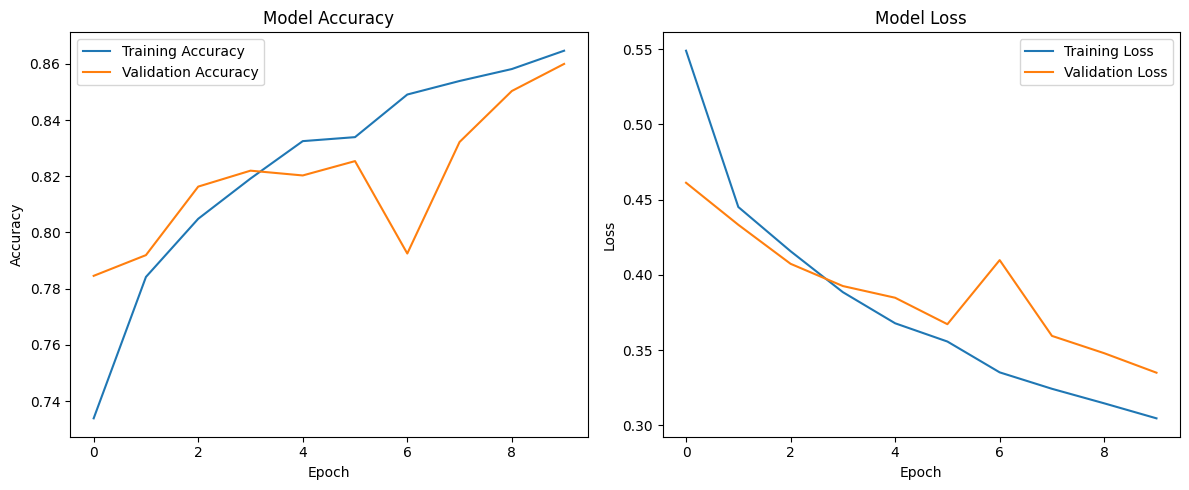

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.plot(history['accuracy'], label='Training Accuracy')
  ax1.plot(history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('Model Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.legend()

  ax2.plot(history['loss'], label='Training Loss')
  ax2.plot(history['val_loss'], label='Validation Loss')
  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend()

  # Display the plot
  plt.tight_layout()
  plt.show()

plot_learning_curve(history.history)

###InceptionV3

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(299, 299),
    batch_size=8)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/test',
    seed=123,
    image_size=(299, 299),
    batch_size=8)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(299, 299),
    batch_size=8)

AUTOTUNE = tf.data.AUTOTUNE

train_ds_ = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_ = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

train_ds_augmented_Inc = train_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_augmented_Inc = val_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

test_ds_processed_Inc = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_augmented_Inc = train_ds_augmented_Inc.prefetch(tf.data.AUTOTUNE)
val_ds_augmented_Inc = val_ds_augmented_Inc.prefetch(tf.data.AUTOTUNE)
test_ds_processed_Inc = test_ds_processed_Inc.prefetch(tf.data.AUTOTUNE)

base_model = InceptionV3(weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3)(x)

Inc_model = Model(inputs=base_model.input, outputs=predictions)

Inc_model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

epochs = 10
history = Inc_model.fit(
    train_ds_augmented_Inc,
    epochs=epochs,
    validation_data=val_ds_augmented_Inc
)

Found 8821 files belonging to 3 classes.
Using 7057 files for training.
Found 1757 files belonging to 3 classes.
Found 8821 files belonging to 3 classes.
Using 1764 files for validation.
Epoch 1/10
883/883 [==============================] - 66s 43ms/step - loss: 0.5444 - accuracy: 0.7513 - val_loss: 0.4460 - val_accuracy: 0.8039
Epoch 2/10
883/883 [==============================] - 29s 32ms/step - loss: 0.4123 - accuracy: 0.8144 - val_loss: 0.4012 - val_accuracy: 0.8328
Epoch 3/10
883/883 [==============================] - 28s 32ms/step - loss: 0.3773 - accuracy: 0.8342 - val_loss: 0.3792 - val_accuracy: 0.8367
Epoch 4/10
883/883 [==============================] - 29s 33ms/step - loss: 0.3487 - accuracy: 0.8494 - val_loss: 0.3798 - val_accuracy: 0.8396
Epoch 5/10
883/883 [==============================] - 34s 39ms/step - loss: 0.3279 - accuracy: 0.8531 - val_loss: 0.3626 - val_accuracy: 0.8617
Epoch 6/10
883/883 [==============================] - 28s 32ms/step - loss: 0.3124 - accuracy

In [ ]:
test_model = tf.keras.models.clone_model(Inc_model)
test_loss, test_accuracy = Inc_model.evaluate(test_ds_processed_Inc)

test_loss, test_accuracy = Inc_model.evaluate(test_ds_processed_Inc)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

220/220 [==============================] - 6s 27ms/step - loss: 0.4103 - accuracy: 0.8321
Test Loss: 0.41031917929649353
Test Accuracy: 0.8321001529693604


1/1 [==============================] - 0s 32ms/step


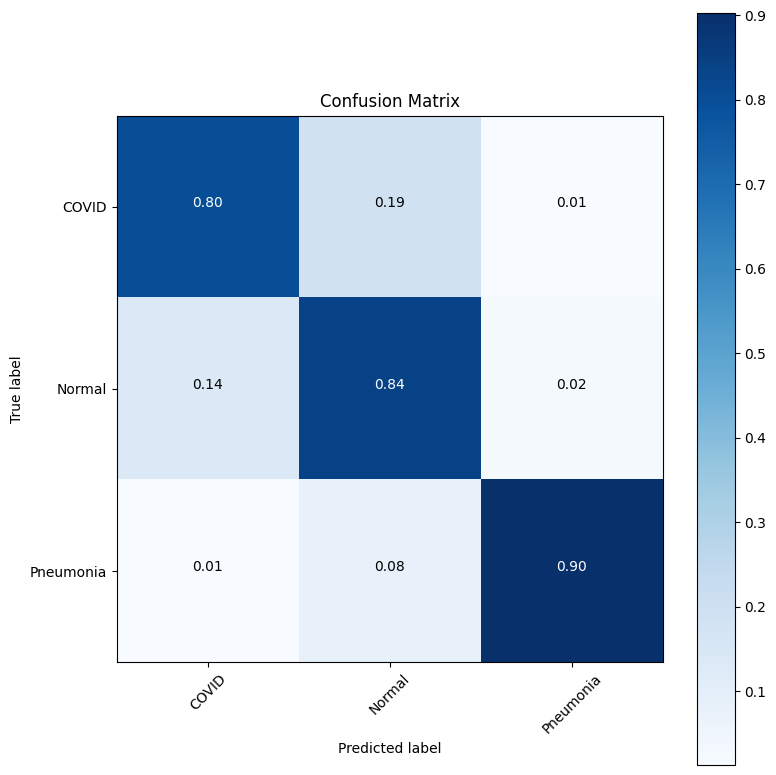

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for img, label in test_ds_processed_Inc:
    y_true.extend(label.numpy())
    predictions = Inc_model.predict(img)
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

fig = plot_confusion_matrix(cm, class_names)
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score
import numpy as np


def calculate_f1_score(model):
    true_labels = []
    predicted_labels = []

    for images, labels in test_ds_processed_Inc:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        print(np.unique(pred_labels))
        true_labels.extend(labels.numpy())
        predicted_labels.extend(pred_labels)

    true_labels = np.array(true_labels).flatten()
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1


f1 = calculate_f1_score(Inc_model)
print("F1 Score:", f1)

1/1 [==============================] - 0s 32ms/step
[0 1]
1/1 [==============================] - 0s 31ms/step
[0 1 2]
1/1 [==============================] - 0s 33ms/step
[0 1]
1/1 [==============================] - 0s 31ms/step
[0 1 2]
1/1 [==============================] - 0s 37ms/step
[0 1 2]
1/1 [==============================] - 0s 31ms/step
[0 1]
1/1 [==============================] - 0s 31ms/step
[0 1 2]
1/1 [==============================] - 0s 32ms/step
[0 1 2]
1/1 [==============================] - 0s 35ms/step
[0 1 2]
1/1 [==============================] - 0s 37ms/step
[0 1 2]
1/1 [==============================] - 0s 35ms/step
[0 1 2]
1/1 [==============================] - 0s 33ms/step
[0 1 2]
1/1 [==============================] - 0s 35ms/step
[0 1 2]
1/1 [==============================] - 0s 33ms/step
[0 1 2]
1/1 [==============================] - 0s 30ms/step
[0 1 2]
1/1 [==============================] - 0s 30ms/step
[0 1]
1/1 [==============================] - 0s 36ms/s

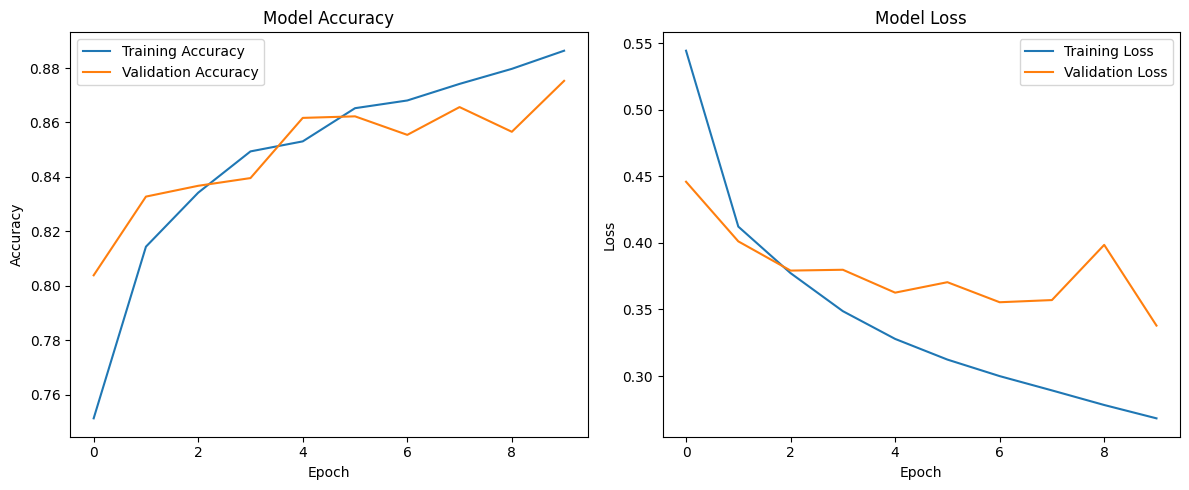

In [ ]:
plot_learning_curve(history.history)

### VGG

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/test',
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE

train_ds_ = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_ = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8821 files belonging to 3 classes.
Using 7057 files for training.
Found 1757 files belonging to 3 classes.
Found 8821 files belonging to 3 classes.
Using 1764 files for validation.


In [ ]:
def preprocess(image, label):
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

train_ds_augmented_VGG = train_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_augmented_VGG = val_ds_.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

test_ds_processed_VGG = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_augmented_VGG = train_ds_augmented_VGG.prefetch(tf.data.AUTOTUNE)
val_ds_augmented_VGG = train_ds_augmented_VGG.prefetch(tf.data.AUTOTUNE)
test_ds_processed_VGG = test_ds_processed_VGG.prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3)(x)

In [ ]:
VGG_model = Model(inputs=base_model.input, outputs=predictions)

VGG_model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 10
history_VGG = VGG_model.fit(
    train_ds_augmented_VGG,
    epochs=epochs,
    validation_data=val_ds_augmented_VGG
)

Epoch 1/10
442/442 [==============================] - 19s 20ms/step - loss: 0.9046 - accuracy: 0.8096 - val_loss: 0.2510 - val_accuracy: 0.8975
Epoch 2/10
442/442 [==============================] - 6s 13ms/step - loss: 0.3424 - accuracy: 0.8712 - val_loss: 0.4138 - val_accuracy: 0.8800
Epoch 3/10
442/442 [==============================] - 9s 19ms/step - loss: 0.3011 - accuracy: 0.8930 - val_loss: 0.1932 - val_accuracy: 0.9163
Epoch 4/10
442/442 [==============================] - 6s 13ms/step - loss: 0.2536 - accuracy: 0.9029 - val_loss: 0.1454 - val_accuracy: 0.9456
Epoch 5/10
442/442 [==============================] - 9s 19ms/step - loss: 0.2373 - accuracy: 0.9141 - val_loss: 0.1343 - val_accuracy: 0.9508
Epoch 6/10
442/442 [==============================] - 6s 13ms/step - loss: 0.2202 - accuracy: 0.9175 - val_loss: 0.1480 - val_accuracy: 0.9411
Epoch 7/10
442/442 [==============================] - 6s 14ms/step - loss: 0.1909 - accuracy: 0.9293 - val_loss: 0.1903 - val_accuracy: 0.934

In [ ]:
test_loss, test_accuracy = VGG_model.evaluate(test_ds_processed_VGG)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

110/110 [==============================] - 4s 33ms/step - loss: 0.2598 - accuracy: 0.9101
Test Loss: 0.2597578465938568
Test Accuracy: 0.91007399559021


In [ ]:
def calculate_f1_score(model):
    true_labels = []
    predicted_labels = []

    for images, labels in test_ds_processed_VGG:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)
        print(np.unique(pred_labels))
        true_labels.extend(labels.numpy())
        predicted_labels.extend(pred_labels)

    true_labels = np.array(true_labels).flatten()
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1


f1 = calculate_f1_score(VGG_model)
print("F1 Score:", f1)

1/1 [==============================] - 0s 234ms/step
[0 1 2]
1/1 [==============================] - 0s 25ms/step
[0 1]
1/1 [==============================] - 0s 19ms/step
[0 1 2]
1/1 [==============================] - 0s 21ms/step
[0 1 2]
1/1 [==============================] - 0s 21ms/step
[0 1 2]
1/1 [==============================] - 0s 21ms/step
[0 1 2]
1/1 [==============================] - 0s 24ms/step
[0 1 2]
1/1 [==============================] - 0s 21ms/step
[0 1 2]
1/1 [==============================] - 0s 21ms/step
[0 1 2]
1/1 [==============================] - 0s 21ms/step
[0 1 2]
1/1 [==============================] - 0s 22ms/step
[0 1 2]
1/1 [==============================] - 0s 25ms/step
[0 1 2]
1/1 [==============================] - 0s 23ms/step
[0 1 2]
1/1 [==============================] - 0s 28ms/step
[0 1 2]
1/1 [==============================] - 0s 21ms/step
[0 1 2]
1/1 [==============================] - 0s 23ms/step
[0 1 2]
1/1 [==============================] - 0s

1/1 [==============================] - 0s 23ms/step


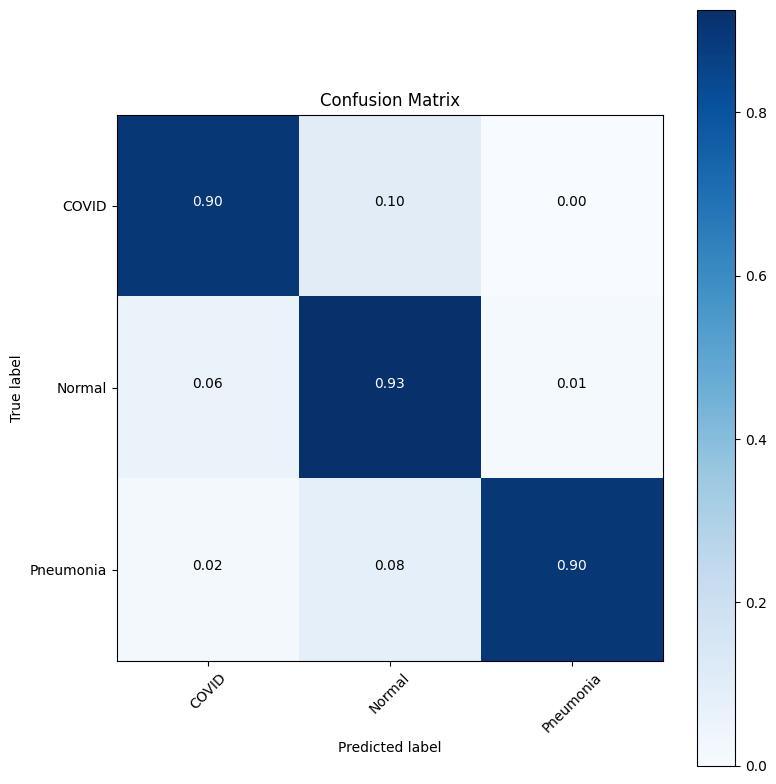

In [ ]:
y_true = []
y_pred = []

for img, label in test_ds_processed_VGG:
    y_true.extend(label.numpy())
    predictions = VGG_model.predict(img)
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

fig = plot_confusion_matrix(cm, class_names)
plt.show()

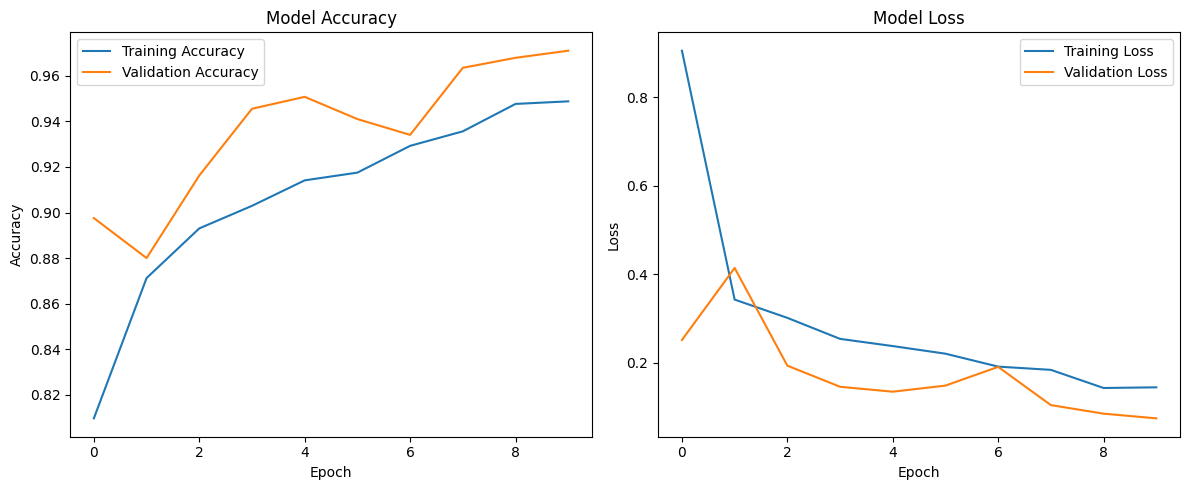

In [ ]:
plot_learning_curve(history_VGG.history)